In [56]:
# Copyright (c) 2017-2019 Uber Technologies, Inc.
# SPDX-License-Identifier: Apache-2.0

"""
This example implements amortized Latent Dirichlet Allocation [1],
demonstrating how to marginalize out discrete assignment variables in a Pyro
model. This model and inference algorithm treat documents as vectors of
categorical variables (vectors of word ids), and collapses word-topic
assignments using Pyro's enumeration. We use PyTorch's reparametrized Gamma and
Dirichlet distributions [2], avoiding the need for Laplace approximations as in
[1]. Following [1] we use the Adam optimizer and clip gradients.

**References:**

[1] Akash Srivastava, Charles Sutton. ICLR 2017.
    "Autoencoding Variational Inference for Topic Models"
    https://arxiv.org/pdf/1703.01488.pdf
[2] Martin Jankowiak, Fritz Obermeyer. ICML 2018.
    "Pathwise gradients beyond the reparametrization trick"
    https://arxiv.org/pdf/1806.01851.pdf
"""
import argparse
import functools
import logging

import torch
from torch import nn
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, JitTraceEnum_ELBO, TraceEnum_ELBO
from pyro.optim import ClippedAdam

import torch.nn as nn
import torch.nn.functional as F
from pyro.infer import SVI, TraceMeanField_ELBO
from tqdm import trange
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import os
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch

assert pyro.__version__.startswith('1.8.1')
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ
from tqdm import tqdm
import matplotlib.pyplot as plt

In [58]:
#Num_word = num_words_per_doc*num_docs
#batch_size = num_docs
num_topics2 = 10
num_words2 = 700
num_words_per_doc2 = 100
num_docs2 = 7
layer_sizes2 = '2-2'
learning_rate2 = 1e-3
batch_size2 = 7
num_steps = 1000

In [59]:
#num_topics = num_topics2, num_words = num_words2, num_words_per_doc = num_words_per_doc2, num_docs = num_docs2, layer_sizes = layer_sizes2, learning_rate = learning_rate2, batch_size = batch_size2

In [60]:
#num_topics = 10, num_words = 25000, num_words_per_doc = 1000, num_docs = 25, layer_sizes = '3-3-3', learning_rate = 1e-3, batch_size = 25

In [61]:
# logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)


# # This is a fully generative model of a batch of documents.
# # data is a [num_words_per_doc, num_documents] shaped array of word ids
# # (specifically it is not a histogram). We assume in this simple example
# # that all documents have the same number of words.
# def model(data=None, num_topics = num_topics2, num_words = num_words2, num_words_per_doc = num_words_per_doc2, num_docs = num_docs2, layer_sizes = layer_sizes2, learning_rate = learning_rate2, batch_size = batch_size2):
#     # Globals.
#     with pyro.plate("topics", num_topics):
#         topic_weights = pyro.sample(
#             "topic_weights", dist.Gamma(1.0 / num_topics, 1.0)
#         )
#         topic_words = pyro.sample(
#             "topic_words", dist.Dirichlet(torch.ones(num_words) / num_words)
#         )

#     # Locals.
#     with pyro.plate("documents", num_docs) as ind:
#         if data is not None:
#             with pyro.util.ignore_jit_warnings():
#                 assert data.shape == (num_words_per_doc, num_docs)
#             data = data[:, ind]
#         doc_topics = pyro.sample("doc_topics", dist.Dirichlet(topic_weights))
#         with pyro.plate("words", num_words_per_doc):
#             # The word_topics variable is marginalized out during inference,
#             # achieved by specifying infer={"enumerate": "parallel"} and using
#             # TraceEnum_ELBO for inference. Thus we can ignore this variable in
#             # the guide.
#             word_topics = pyro.sample(
#                 "word_topics",
#                 dist.Categorical(doc_topics),
#                 infer={"enumerate": "parallel"},
#             )
#             data = pyro.sample(
#                 "doc_words", dist.Categorical(topic_words[word_topics]), obs=data
#             )

#     return topic_weights, topic_words, data


# # We will use amortized inference of the local topic variables, achieved by a
# # multi-layer perceptron. We'll wrap the guide in an nn.Module.
# def make_predictor(num_topics = num_topics2, num_words = num_words2, num_words_per_doc = num_words_per_doc2, num_docs = num_docs2, layer_sizes = layer_sizes2, learning_rate = learning_rate2, batch_size = batch_size2):
#     layer_sizes = (
#         [num_words]
#         + [int(s) for s in layer_sizes.split("-")]
#         + [num_topics]
#     )
#     logging.info("Creating MLP with sizes {}".format(layer_sizes))
#     layers = []
#     for in_size, out_size in zip(layer_sizes, layer_sizes[1:]):
#         layer = nn.Linear(in_size, out_size)
#         layer.weight.data.normal_(0, 0.001)
#         layer.bias.data.normal_(0, 0.001)
#         layers.append(layer)
#         layers.append(nn.Sigmoid())
#     layers.append(nn.Softmax(dim=-1))
#     return nn.Sequential(*layers)


# def parametrized_guide(predictor, data, num_topics = num_topics2, num_words = num_words2, num_words_per_doc = num_words_per_doc2, num_docs = num_docs2, layer_sizes = layer_sizes2, learning_rate = learning_rate2, batch_size = batch_size2):
#     # Use a conjugate guide for global variables.
#     topic_weights_posterior = pyro.param(
#         "topic_weights_posterior",
#         lambda: torch.ones(num_topics),
#         constraint=constraints.positive,
#     )
#     topic_words_posterior = pyro.param(
#         "topic_words_posterior",
#         lambda: torch.ones(num_topics, num_words),
#         constraint=constraints.greater_than(0.5),
#     )
#     with pyro.plate("topics", num_topics):
#         pyro.sample("topic_weights", dist.Gamma(topic_weights_posterior, 1.0))
#         pyro.sample("topic_words", dist.Dirichlet(topic_words_posterior))

#     # Use an amortized guide for local variables.
#     pyro.module("predictor", predictor)
#     with pyro.plate("documents", num_docs, batch_size) as ind:
#         data = data[:, ind]
#         # The neural network will operate on histograms rather than word
#         # index vectors, so we'll convert the raw data to a histogram.
#         counts = torch.zeros(num_words, ind.size(0)).scatter_add(
#             0, data, torch.ones(data.shape)
#         )
#         doc_topics = predictor(counts.transpose(0, 1))
#         pyro.sample("doc_topics", dist.Delta(doc_topics, event_dim=1))


# def main(num_topics = num_topics2, num_words = num_words2, num_words_per_doc = num_words_per_doc2, num_docs = num_docs2, layer_sizes = layer_sizes2, learning_rate = learning_rate2, batch_size = batch_size2):
#     logging.info("Generating data")
#     pyro.set_rng_seed(0)
#     pyro.clear_param_store()

#     # We can generate synthetic data directly by calling the model.
#     true_topic_weights, true_topic_words, data = model(num_topics = num_topics2, num_words = num_words2, num_words_per_doc = num_words_per_doc2, num_docs = num_docs2, layer_sizes = layer_sizes2, learning_rate = learning_rate2, batch_size = batch_size2)

#     # We'll train using SVI.
#     logging.info("-" * 40)
#     logging.info("Training on {} documents".format(num_docs))
#     predictor = make_predictor(num_topics = num_topics2, num_words = num_words2, num_words_per_doc = num_words_per_doc2, num_docs = num_docs2, layer_sizes = layer_sizes2, learning_rate = learning_rate2, batch_size = batch_size2)
#     guide = functools.partial(parametrized_guide, predictor)
#     Elbo = JitTraceEnum_ELBO #if args.jit else TraceEnum_ELBO
#     elbo = Elbo(max_plate_nesting=2)
#     optim = ClippedAdam({"lr": learning_rate})
#     svi = SVI(model, guide, optim, elbo)
#     logging.info("Step\tLoss")
#     for step in tqdm(range(num_steps)):
#         loss = svi.step(num_topics = num_topics2, num_words = num_words2, num_words_per_doc = num_words_per_doc2, num_docs = num_docs2, layer_sizes = layer_sizes2, learning_rate = learning_rate2, batch_size = batch_size2)
#         if step % 10 == 0:
#             logging.info("{: >5d}\t{}".format(step, loss))
#     loss = elbo.loss(model, guide, data, num_topics = num_topics2, num_words = num_words2, num_words_per_doc = num_words_per_doc2, num_docs = num_docs2, layer_sizes = layer_sizes2, learning_rate = learning_rate2, batch_size = batch_size2)
#     logging.info("final loss = {}".format(loss))




In [62]:
def model(data=None, num_topics = num_topics2, num_words = num_words2, num_words_per_doc = num_words_per_doc2, num_docs = num_docs2, layer_sizes = layer_sizes2, learning_rate = learning_rate2, batch_size = batch_size2):
    # Globals.
    with pyro.plate("topics", num_topics):
        topic_weights = pyro.sample(
            "topic_weights", dist.Gamma(1.0 / num_topics, 1.0)
        )
        topic_words = pyro.sample(
            "topic_words", dist.Dirichlet(torch.ones(num_words) / num_words)
        )

    # Locals.
    with pyro.plate("documents", num_docs) as ind:
        if data is not None:
            with pyro.util.ignore_jit_warnings():
                assert data.shape == (num_words_per_doc, num_docs)
            data = data[:, ind]
        doc_topics = pyro.sample("doc_topics", dist.Dirichlet(topic_weights))
        with pyro.plate("words", num_words_per_doc):
            # The word_topics variable is marginalized out during inference,
            # achieved by specifying infer={"enumerate": "parallel"} and using
            # TraceEnum_ELBO for inference. Thus we can ignore this variable in
            # the guide.
            word_topics = pyro.sample(
                "word_topics",
                dist.Categorical(doc_topics),
                infer={"enumerate": "parallel"},
            )
            data = pyro.sample(
                "doc_words", dist.Categorical(topic_words[word_topics]), obs=data
            )

    return topic_weights, topic_words, data


# We will use amortized inference of the local topic variables, achieved by a
# multi-layer perceptron. We'll wrap the guide in an nn.Module.
def make_predictor(num_topics = num_topics2, num_words = num_words2, num_words_per_doc = num_words_per_doc2, num_docs = num_docs2, layer_sizes = layer_sizes2, learning_rate = learning_rate2, batch_size = batch_size2):
    layer_sizes = (
        [num_words]
        + [int(s) for s in layer_sizes.split("-")]
        + [num_topics]
    )
    logging.info("Creating MLP with sizes {}".format(layer_sizes))
    layers = []
    for in_size, out_size in zip(layer_sizes, layer_sizes[1:]):
        layer = nn.Linear(in_size, out_size)
        layer.weight.data.normal_(0, 0.001)
        layer.bias.data.normal_(0, 0.001)
        layers.append(layer)
        layers.append(nn.Sigmoid())
    layers.append(nn.Softmax(dim=-1))
    return nn.Sequential(*layers)


def parametrized_guide(predictor, data, num_topics = num_topics2, num_words = num_words2, num_words_per_doc = num_words_per_doc2, num_docs = num_docs2, layer_sizes = layer_sizes2, learning_rate = learning_rate2, batch_size = batch_size2):
    # Use a conjugate guide for global variables.
    topic_weights_posterior = pyro.param(
        "topic_weights_posterior",
        lambda: torch.ones(num_topics),
        constraint=constraints.positive,
    )
    topic_words_posterior = pyro.param(
        "topic_words_posterior",
        lambda: torch.ones(num_topics, num_words),
        constraint=constraints.greater_than(0.5),
    )
    with pyro.plate("topics", num_topics):
        pyro.sample("topic_weights", dist.Gamma(topic_weights_posterior, 1.0))
        pyro.sample("topic_words", dist.Dirichlet(topic_words_posterior))

    # Use an amortized guide for local variables.
    pyro.module("predictor", predictor)
    with pyro.plate("documents", num_docs, batch_size) as ind:
        data = data[:, ind]
        # The neural network will operate on histograms rather than word
        # index vectors, so we'll convert the raw data to a histogram.
        counts = torch.zeros(num_words, ind.size(0)).scatter_add(
            0, data, torch.ones(data.shape)
        )
        doc_topics = predictor(counts.transpose(0, 1))
        pyro.sample("doc_topics", dist.Delta(doc_topics, event_dim=1))


def main(num_topics = num_topics2, num_words = num_words2, num_words_per_doc = num_words_per_doc2, num_docs = num_docs2, layer_sizes = layer_sizes2, learning_rate = learning_rate2, batch_size = batch_size2):
    logging.info("Generating data")
    pyro.set_rng_seed(0)
    pyro.clear_param_store()
    tot_loss = []
    tot_num_steps = []
    # We can generate synthetic data directly by calling the model.
    true_topic_weights, true_topic_words, data = model(num_topics = num_topics2, num_words = num_words2, num_words_per_doc = num_words_per_doc2, num_docs = num_docs2, layer_sizes = layer_sizes2, learning_rate = learning_rate2, batch_size = batch_size2)

    # We'll train using SVI.
    logging.info("-" * 40)
    logging.info("Training on {} documents".format(num_docs))
    predictor = make_predictor(num_topics = num_topics2, num_words = num_words2, num_words_per_doc = num_words_per_doc2, num_docs = num_docs2, layer_sizes = layer_sizes2, learning_rate = learning_rate2, batch_size = batch_size2)
    guide = functools.partial(parametrized_guide, predictor)
    Elbo = JitTraceEnum_ELBO# if args.jit else TraceEnum_ELBO
    elbo = Elbo(max_plate_nesting=2)
    optim = ClippedAdam({"lr": learning_rate})
    svi = SVI(model, guide, optim, elbo)
    logging.info("Step\tLoss")
    for step in tqdm(range(num_steps)):
        loss = svi.step(data, num_topics = num_topics2, num_words = num_words2, num_words_per_doc = num_words_per_doc2, num_docs = num_docs2, layer_sizes = layer_sizes2, learning_rate = learning_rate2, batch_size = batch_size2)
        tot_loss.append(loss)
        tot_num_steps.append(step)
        if step % 10 == 0:
            logging.info("{: >5d}\t{}".format(step, loss))
    loss = elbo.loss(model, guide, data, num_topics = num_topics2, num_words = num_words2, num_words_per_doc = num_words_per_doc2, num_docs = num_docs2, layer_sizes = layer_sizes2, learning_rate = learning_rate2, batch_size = batch_size2)
    plt.plot(tot_num_steps, tot_loss)
    logging.info("final loss = {}".format(loss))
    

100%|███████████████████████████████████████| 1000/1000 [00:27<00:00, 36.39it/s]


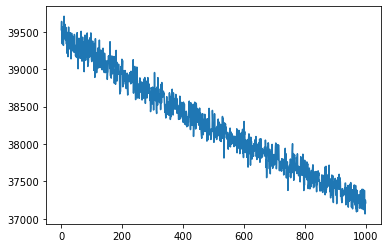

In [63]:
main()

In [12]:
for name, value in pyro.get_param_store().items():
    print(name)

topic_weights_posterior
topic_words_posterior
predictor$$$0.weight
predictor$$$0.bias
predictor$$$2.weight
predictor$$$2.bias
predictor$$$4.weight
predictor$$$4.bias


In [6]:
news = fetch_20newsgroups(subset='all')
vectorizer = CountVectorizer(max_df=0.5, min_df=20, stop_words='english')
docs = torch.from_numpy(vectorizer.fit_transform(news['data']).toarray())

vocab = pd.DataFrame(columns=['word', 'index'])
vocab['word'] = vectorizer.get_feature_names()
vocab['index'] = vocab.index

/Users/bennetthellman/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
